In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'random_occlusion', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'blur', 'original', 'dirty_lens'}
Validation folders considered: {'random_occlusion', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'blur', 'original', 'dirty_lens'}
Test folders considered: {'random_occlusion', 'motion_blur', 'lens_flare', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'blur', 'original', 'dirty_lens'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'motion_blur', 'lens_flare', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'blur', 'original', 'dirty_lens'}
Validation folders considered: {'motion_blur', 'lens_flare', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'blur', 'original', 'dirty_lens'}
Test folders considered: {'motion_blur', 'lens_flare', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'blur', 'original', 'dirty_lens'}


In [7]:
classes = train_ds.classes
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

Classes: ['fast_bowl', 'spin_bowl']
Number of classes: 2
Train samples: 1520
Val samples: 384
Test samples: 488


In [8]:
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.models as models

In [9]:
# -----------------------------
# 2. Pretrained DenseNet121 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained DenseNet121
print("🔄 Loading pretrained DenseNet121 from ImageNet...")
model = models.densenet121(pretrained=True)

# Replace final classification layer
num_features = model.classifier.in_features  # Get input features (1024)
model.classifier = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"✅ Model loaded with {len(classes)} output classes")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Alternative model info (without torchsummary)
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ DenseNet121 features: 1024")
print(f"│ Output classes: {len(classes)}")

Using device: cuda
🔄 Loading pretrained DenseNet121 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 169MB/s]


✅ Model loaded with 2 output classes
📊 Total parameters: 6,955,906
📊 Trainable parameters: 6,955,906
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ DenseNet121 features: 1024
│ Output classes: 2



📋 Training Configuration:
│ Model: DenseNet121 (pretrained)
│ Optimizer: Adam (lr=0.0001)
│ Loss Function: CrossEntropyLoss
│ Batch Size: 32
│ Device: cuda

🚀 Starting DenseNet121 Fine-tuning for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:33<00:00,  1.41it/s, Loss=0.4174, Acc=0.8125]


✅ Training completed in 33.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:04<00:00,  2.40it/s, Loss=0.5422, Acc=0.7526]


✅ Validation completed in 5.00s
🌟 New best model found! Validation Loss: 0.5422

📊 Epoch 1 Summary:
│ Train Loss: 0.4174 | Train Acc: 0.8125
│ Val Loss:   0.5422 | Val Acc:   0.7526
│ Train Time: 33.95s | Val Time: 5.00s
│ Total Epoch Time: 38.96s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.89it/s, Loss=0.0621, Acc=0.9947]


✅ Training completed in 25.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.71it/s, Loss=0.6791, Acc=0.7474]


✅ Validation completed in 3.24s

📊 Epoch 2 Summary:
│ Train Loss: 0.0621 | Train Acc: 0.9947
│ Val Loss:   0.6791 | Val Acc:   0.7474
│ Train Time: 25.44s | Val Time: 3.24s
│ Total Epoch Time: 28.69s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.86it/s, Loss=0.0134, Acc=0.9993]


✅ Training completed in 25.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.64it/s, Loss=0.7925, Acc=0.7500]


✅ Validation completed in 3.30s

📊 Epoch 3 Summary:
│ Train Loss: 0.0134 | Train Acc: 0.9993
│ Val Loss:   0.7925 | Val Acc:   0.7500
│ Train Time: 25.75s | Val Time: 3.30s
│ Total Epoch Time: 29.05s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.86it/s, Loss=0.0080, Acc=1.0000]


✅ Training completed in 25.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.68it/s, Loss=0.7675, Acc=0.7812]


✅ Validation completed in 3.26s

📊 Epoch 4 Summary:
│ Train Loss: 0.0080 | Train Acc: 1.0000
│ Val Loss:   0.7675 | Val Acc:   0.7812
│ Train Time: 25.80s | Val Time: 3.26s
│ Total Epoch Time: 29.06s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.85it/s, Loss=0.0139, Acc=0.9987]


✅ Training completed in 25.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.70it/s, Loss=0.7958, Acc=0.7214]


✅ Validation completed in 3.25s

📊 Epoch 5 Summary:
│ Train Loss: 0.0139 | Train Acc: 0.9987
│ Val Loss:   0.7958 | Val Acc:   0.7214
│ Train Time: 25.88s | Val Time: 3.25s
│ Total Epoch Time: 29.13s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.81it/s, Loss=0.0108, Acc=0.9980]


✅ Training completed in 26.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.57it/s, Loss=0.8242, Acc=0.7682]


✅ Validation completed in 3.36s

📊 Epoch 6 Summary:
│ Train Loss: 0.0108 | Train Acc: 0.9980
│ Val Loss:   0.8242 | Val Acc:   0.7682
│ Train Time: 26.53s | Val Time: 3.36s
│ Total Epoch Time: 29.90s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0183, Acc=0.9941]


✅ Training completed in 27.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.59it/s, Loss=1.0296, Acc=0.6536]


✅ Validation completed in 3.34s

📊 Epoch 7 Summary:
│ Train Loss: 0.0183 | Train Acc: 0.9941
│ Val Loss:   1.0296 | Val Acc:   0.6536
│ Train Time: 27.02s | Val Time: 3.34s
│ Total Epoch Time: 30.37s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.76it/s, Loss=0.0156, Acc=0.9954]


✅ Training completed in 27.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.70it/s, Loss=1.2328, Acc=0.7161]


✅ Validation completed in 3.25s

📊 Epoch 8 Summary:
│ Train Loss: 0.0156 | Train Acc: 0.9954
│ Val Loss:   1.2328 | Val Acc:   0.7161
│ Train Time: 27.25s | Val Time: 3.25s
│ Total Epoch Time: 30.50s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0104, Acc=0.9974]


✅ Training completed in 26.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.61it/s, Loss=0.9955, Acc=0.7318]


✅ Validation completed in 3.33s

📊 Epoch 9 Summary:
│ Train Loss: 0.0104 | Train Acc: 0.9974
│ Val Loss:   0.9955 | Val Acc:   0.7318
│ Train Time: 26.82s | Val Time: 3.33s
│ Total Epoch Time: 30.15s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0073, Acc=0.9980]


✅ Training completed in 27.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.52it/s, Loss=1.1804, Acc=0.7292]


✅ Validation completed in 3.41s

📊 Epoch 10 Summary:
│ Train Loss: 0.0073 | Train Acc: 0.9980
│ Val Loss:   1.1804 | Val Acc:   0.7292
│ Train Time: 27.19s | Val Time: 3.41s
│ Total Epoch Time: 30.60s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0039, Acc=0.9993]


✅ Training completed in 27.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.52it/s, Loss=1.0730, Acc=0.7266]


✅ Validation completed in 3.41s

📊 Epoch 11 Summary:
│ Train Loss: 0.0039 | Train Acc: 0.9993
│ Val Loss:   1.0730 | Val Acc:   0.7266
│ Train Time: 27.07s | Val Time: 3.41s
│ Total Epoch Time: 30.48s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0046, Acc=0.9987]


✅ Training completed in 26.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.50it/s, Loss=1.1409, Acc=0.7578]


✅ Validation completed in 3.43s

📊 Epoch 12 Summary:
│ Train Loss: 0.0046 | Train Acc: 0.9987
│ Val Loss:   1.1409 | Val Acc:   0.7578
│ Train Time: 26.96s | Val Time: 3.43s
│ Total Epoch Time: 30.40s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0027, Acc=1.0000]


✅ Training completed in 26.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.59it/s, Loss=1.1973, Acc=0.7448]


✅ Validation completed in 3.35s

📊 Epoch 13 Summary:
│ Train Loss: 0.0027 | Train Acc: 1.0000
│ Val Loss:   1.1973 | Val Acc:   0.7448
│ Train Time: 26.88s | Val Time: 3.35s
│ Total Epoch Time: 30.23s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.74it/s, Loss=0.0113, Acc=0.9980]


✅ Training completed in 27.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.61it/s, Loss=1.2081, Acc=0.7500]


✅ Validation completed in 3.33s

📊 Epoch 14 Summary:
│ Train Loss: 0.0113 | Train Acc: 0.9980
│ Val Loss:   1.2081 | Val Acc:   0.7500
│ Train Time: 27.51s | Val Time: 3.33s
│ Total Epoch Time: 30.85s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0091, Acc=0.9980]


✅ Training completed in 27.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.54it/s, Loss=1.0552, Acc=0.7240]


✅ Validation completed in 3.40s

📊 Epoch 15 Summary:
│ Train Loss: 0.0091 | Train Acc: 0.9980
│ Val Loss:   1.0552 | Val Acc:   0.7240
│ Train Time: 27.04s | Val Time: 3.40s
│ Total Epoch Time: 30.45s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0190, Acc=0.9954]


✅ Training completed in 27.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.65it/s, Loss=0.9689, Acc=0.7448]


✅ Validation completed in 3.29s

📊 Epoch 16 Summary:
│ Train Loss: 0.0190 | Train Acc: 0.9954
│ Val Loss:   0.9689 | Val Acc:   0.7448
│ Train Time: 27.11s | Val Time: 3.29s
│ Total Epoch Time: 30.40s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0110, Acc=0.9967]


✅ Training completed in 27.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.48it/s, Loss=1.0519, Acc=0.7370]


✅ Validation completed in 3.45s

📊 Epoch 17 Summary:
│ Train Loss: 0.0110 | Train Acc: 0.9967
│ Val Loss:   1.0519 | Val Acc:   0.7370
│ Train Time: 27.03s | Val Time: 3.45s
│ Total Epoch Time: 30.48s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0065, Acc=0.9987]


✅ Training completed in 27.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.48it/s, Loss=0.9202, Acc=0.7370]


✅ Validation completed in 3.45s

📊 Epoch 18 Summary:
│ Train Loss: 0.0065 | Train Acc: 0.9987
│ Val Loss:   0.9202 | Val Acc:   0.7370
│ Train Time: 27.15s | Val Time: 3.45s
│ Total Epoch Time: 30.60s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0062, Acc=0.9980]


✅ Training completed in 26.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.60it/s, Loss=1.1337, Acc=0.7630]


✅ Validation completed in 3.34s

📊 Epoch 19 Summary:
│ Train Loss: 0.0062 | Train Acc: 0.9980
│ Val Loss:   1.1337 | Val Acc:   0.7630
│ Train Time: 26.89s | Val Time: 3.34s
│ Total Epoch Time: 30.24s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0071, Acc=0.9980]


✅ Training completed in 27.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.55it/s, Loss=1.2142, Acc=0.7109]


✅ Validation completed in 3.38s

📊 Epoch 20 Summary:
│ Train Loss: 0.0071 | Train Acc: 0.9980
│ Val Loss:   1.2142 | Val Acc:   0.7109
│ Train Time: 27.06s | Val Time: 3.38s
│ Total Epoch Time: 30.45s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0033, Acc=1.0000]


✅ Training completed in 26.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.57it/s, Loss=1.1648, Acc=0.7370]


✅ Validation completed in 3.36s

📊 Epoch 21 Summary:
│ Train Loss: 0.0033 | Train Acc: 1.0000
│ Val Loss:   1.1648 | Val Acc:   0.7370
│ Train Time: 26.79s | Val Time: 3.36s
│ Total Epoch Time: 30.15s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0006, Acc=1.0000]


✅ Training completed in 27.00s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.63it/s, Loss=1.2174, Acc=0.7552]


✅ Validation completed in 3.31s

📊 Epoch 22 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   1.2174 | Val Acc:   0.7552
│ Train Time: 27.00s | Val Time: 3.31s
│ Total Epoch Time: 30.32s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0013, Acc=1.0000]


✅ Training completed in 26.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.61it/s, Loss=1.2226, Acc=0.7474]


✅ Validation completed in 3.33s

📊 Epoch 23 Summary:
│ Train Loss: 0.0013 | Train Acc: 1.0000
│ Val Loss:   1.2226 | Val Acc:   0.7474
│ Train Time: 26.87s | Val Time: 3.33s
│ Total Epoch Time: 30.20s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0003, Acc=1.0000]


✅ Training completed in 27.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.47it/s, Loss=1.2392, Acc=0.7474]


✅ Validation completed in 3.46s

📊 Epoch 24 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.2392 | Val Acc:   0.7474
│ Train Time: 27.01s | Val Time: 3.46s
│ Total Epoch Time: 30.47s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0007, Acc=1.0000]


✅ Training completed in 26.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.59it/s, Loss=1.2402, Acc=0.7474]


✅ Validation completed in 3.35s

📊 Epoch 25 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   1.2402 | Val Acc:   0.7474
│ Train Time: 26.92s | Val Time: 3.35s
│ Total Epoch Time: 30.27s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0009, Acc=1.0000]


✅ Training completed in 26.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.49it/s, Loss=1.1556, Acc=0.7578]


✅ Validation completed in 3.45s

📊 Epoch 26 Summary:
│ Train Loss: 0.0009 | Train Acc: 1.0000
│ Val Loss:   1.1556 | Val Acc:   0.7578
│ Train Time: 26.99s | Val Time: 3.45s
│ Total Epoch Time: 30.44s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0002, Acc=1.0000]


✅ Training completed in 26.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.43it/s, Loss=1.1941, Acc=0.7578]


✅ Validation completed in 3.50s

📊 Epoch 27 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.1941 | Val Acc:   0.7578
│ Train Time: 26.77s | Val Time: 3.50s
│ Total Epoch Time: 30.28s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0003, Acc=1.0000]


✅ Training completed in 27.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.52it/s, Loss=1.2230, Acc=0.7604]


✅ Validation completed in 3.41s

📊 Epoch 28 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.2230 | Val Acc:   0.7604
│ Train Time: 27.06s | Val Time: 3.41s
│ Total Epoch Time: 30.48s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0003, Acc=1.0000]


✅ Training completed in 26.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.52it/s, Loss=1.2496, Acc=0.7422]


✅ Validation completed in 3.41s

📊 Epoch 29 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.2496 | Val Acc:   0.7422
│ Train Time: 26.87s | Val Time: 3.41s
│ Total Epoch Time: 30.28s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0002, Acc=1.0000]


✅ Training completed in 27.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.61it/s, Loss=1.2222, Acc=0.7604]


✅ Validation completed in 3.32s

📊 Epoch 30 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2222 | Val Acc:   0.7604
│ Train Time: 27.05s | Val Time: 3.32s
│ Total Epoch Time: 30.38s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.76it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.51it/s, Loss=1.2100, Acc=0.7630]


✅ Validation completed in 3.42s

📊 Epoch 31 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.2100 | Val Acc:   0.7630
│ Train Time: 27.20s | Val Time: 3.42s
│ Total Epoch Time: 30.63s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0002, Acc=1.0000]


✅ Training completed in 27.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.60it/s, Loss=1.2363, Acc=0.7526]


✅ Validation completed in 3.33s

📊 Epoch 32 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2363 | Val Acc:   0.7526
│ Train Time: 27.07s | Val Time: 3.33s
│ Total Epoch Time: 30.41s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 26.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.54it/s, Loss=1.2189, Acc=0.7630]


✅ Validation completed in 3.40s

📊 Epoch 33 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.2189 | Val Acc:   0.7630
│ Train Time: 26.81s | Val Time: 3.40s
│ Total Epoch Time: 30.22s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.64it/s, Loss=1.2582, Acc=0.7552]


✅ Validation completed in 3.30s

📊 Epoch 34 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.2582 | Val Acc:   0.7552
│ Train Time: 27.11s | Val Time: 3.30s
│ Total Epoch Time: 30.42s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0005, Acc=1.0000]


✅ Training completed in 26.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.55it/s, Loss=1.3531, Acc=0.7396]


✅ Validation completed in 3.39s

📊 Epoch 35 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   1.3531 | Val Acc:   0.7396
│ Train Time: 26.78s | Val Time: 3.39s
│ Total Epoch Time: 30.17s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0007, Acc=1.0000]


✅ Training completed in 27.00s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.65it/s, Loss=1.3001, Acc=0.7630]


✅ Validation completed in 3.29s

📊 Epoch 36 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   1.3001 | Val Acc:   0.7630
│ Train Time: 27.00s | Val Time: 3.29s
│ Total Epoch Time: 30.30s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0006, Acc=1.0000]


✅ Training completed in 26.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.57it/s, Loss=1.2924, Acc=0.7344]


✅ Validation completed in 3.37s

📊 Epoch 37 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   1.2924 | Val Acc:   0.7344
│ Train Time: 26.97s | Val Time: 3.37s
│ Total Epoch Time: 30.35s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0003, Acc=1.0000]


✅ Training completed in 26.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.64it/s, Loss=1.3058, Acc=0.7552]


✅ Validation completed in 3.30s

📊 Epoch 38 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.3058 | Val Acc:   0.7552
│ Train Time: 26.89s | Val Time: 3.30s
│ Total Epoch Time: 30.19s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.50it/s, Loss=1.3051, Acc=0.7604]


✅ Validation completed in 3.43s

📊 Epoch 39 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3051 | Val Acc:   0.7604
│ Train Time: 27.11s | Val Time: 3.43s
│ Total Epoch Time: 30.54s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0002, Acc=1.0000]


✅ Training completed in 27.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.53it/s, Loss=1.2863, Acc=0.7500]


✅ Validation completed in 3.40s

📊 Epoch 40 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2863 | Val Acc:   0.7500
│ Train Time: 27.03s | Val Time: 3.40s
│ Total Epoch Time: 30.43s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0002, Acc=1.0000]


✅ Training completed in 27.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.52it/s, Loss=1.3222, Acc=0.7604]


✅ Validation completed in 3.41s

📊 Epoch 41 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.3222 | Val Acc:   0.7604
│ Train Time: 27.05s | Val Time: 3.41s
│ Total Epoch Time: 30.46s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.76it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.71it/s, Loss=1.3566, Acc=0.7604]


✅ Validation completed in 3.24s

📊 Epoch 42 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3566 | Val Acc:   0.7604
│ Train Time: 27.23s | Val Time: 3.24s
│ Total Epoch Time: 30.48s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.53it/s, Loss=1.3232, Acc=0.7630]


✅ Validation completed in 3.40s

📊 Epoch 43 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3232 | Val Acc:   0.7630
│ Train Time: 27.12s | Val Time: 3.40s
│ Total Epoch Time: 30.53s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 26.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.66it/s, Loss=1.3661, Acc=0.7552]


✅ Validation completed in 3.28s

📊 Epoch 44 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3661 | Val Acc:   0.7552
│ Train Time: 26.89s | Val Time: 3.28s
│ Total Epoch Time: 30.18s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.54it/s, Loss=1.3328, Acc=0.7578]


✅ Validation completed in 3.39s

📊 Epoch 45 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3328 | Val Acc:   0.7578
│ Train Time: 27.06s | Val Time: 3.39s
│ Total Epoch Time: 30.46s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.78it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.69it/s, Loss=1.4019, Acc=0.7578]


✅ Validation completed in 3.25s

📊 Epoch 46 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4019 | Val Acc:   0.7578
│ Train Time: 27.01s | Val Time: 3.25s
│ Total Epoch Time: 30.27s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:27<00:00,  1.77it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 27.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.56it/s, Loss=1.3975, Acc=0.7500]


✅ Validation completed in 3.37s

📊 Epoch 47 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3975 | Val Acc:   0.7500
│ Train Time: 27.07s | Val Time: 3.37s
│ Total Epoch Time: 30.44s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 26.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.50it/s, Loss=1.3535, Acc=0.7578]


✅ Validation completed in 3.44s

📊 Epoch 48 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3535 | Val Acc:   0.7578
│ Train Time: 26.96s | Val Time: 3.44s
│ Total Epoch Time: 30.40s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.78it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 26.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.68it/s, Loss=1.3681, Acc=0.7682]


✅ Validation completed in 3.26s

📊 Epoch 49 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3681 | Val Acc:   0.7682
│ Train Time: 26.96s | Val Time: 3.26s
│ Total Epoch Time: 30.23s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.79it/s, Loss=0.0001, Acc=1.0000]


✅ Training completed in 26.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.60it/s, Loss=1.3752, Acc=0.7682]


✅ Validation completed in 3.34s

📊 Epoch 50 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.3752 | Val Acc:   0.7682
│ Train Time: 26.88s | Val Time: 3.34s
│ Total Epoch Time: 30.22s
│ Best Val Loss: 0.5422 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

💾 Best model saved as 'best_cricket_densenet121.pth'
📊 Best model stats:
│ Best Epoch: 1
│ Best Val Loss: 0.5422
│ Best Val Acc: 0.7526

💾 Training history saved to 'cricket_densenet121_history_pretrained.csv'

🎉 DenseNet121 Fine-tuning Complete!
Total Training Time: 1521.61s (25.4 minutes)
Average Epoch Time: 30.43s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 1 loaded successfully!


Testing: 100%|██████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


✅ Testing completed in 7.02s

📋 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.78      0.87      0.82       304
   spin_bowl       0.73      0.60      0.66       184

    accuracy                           0.76       488
   macro avg       0.75      0.73      0.74       488
weighted avg       0.76      0.76      0.76       488

🎯 Test Accuracy: 0.7643

📊 Cricket Classification Performance (DenseNet121):
│ Best Validation Loss: 0.5422 (Epoch 1)
│ Best Validation Acc:  0.7526 (Epoch 1)
│ Final Test Accuracy:  0.7643
│ Val-Test Gap:         0.0117

💾 Files saved:
│ best_cricket_densenet121.pth - Best model weights
│ cricket_densenet121_history.csv - Training metrics


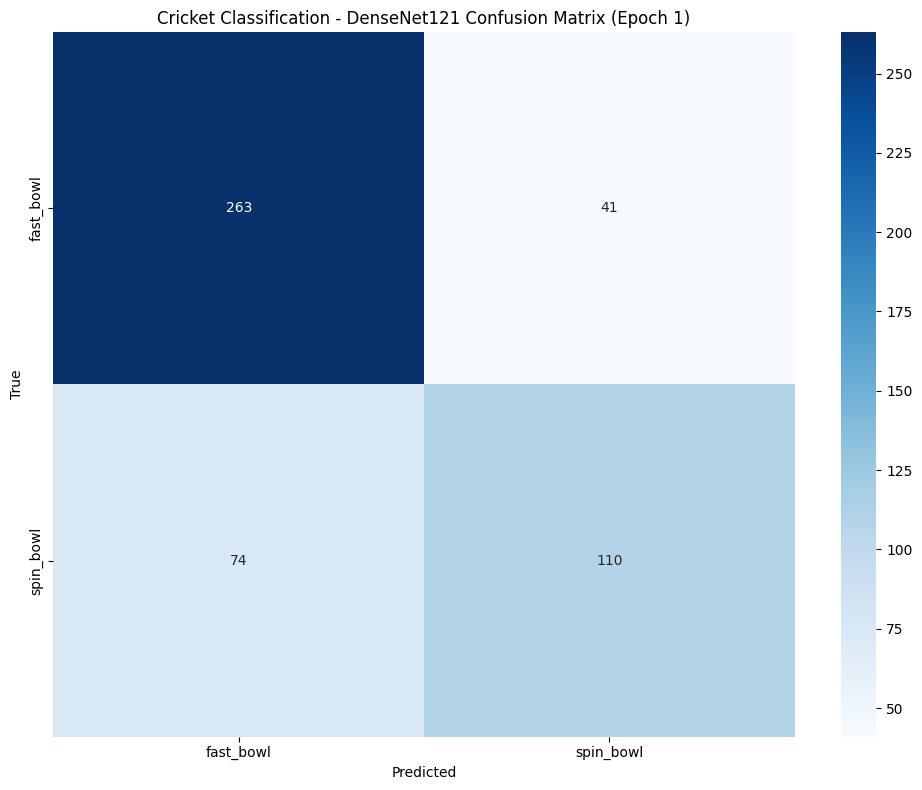

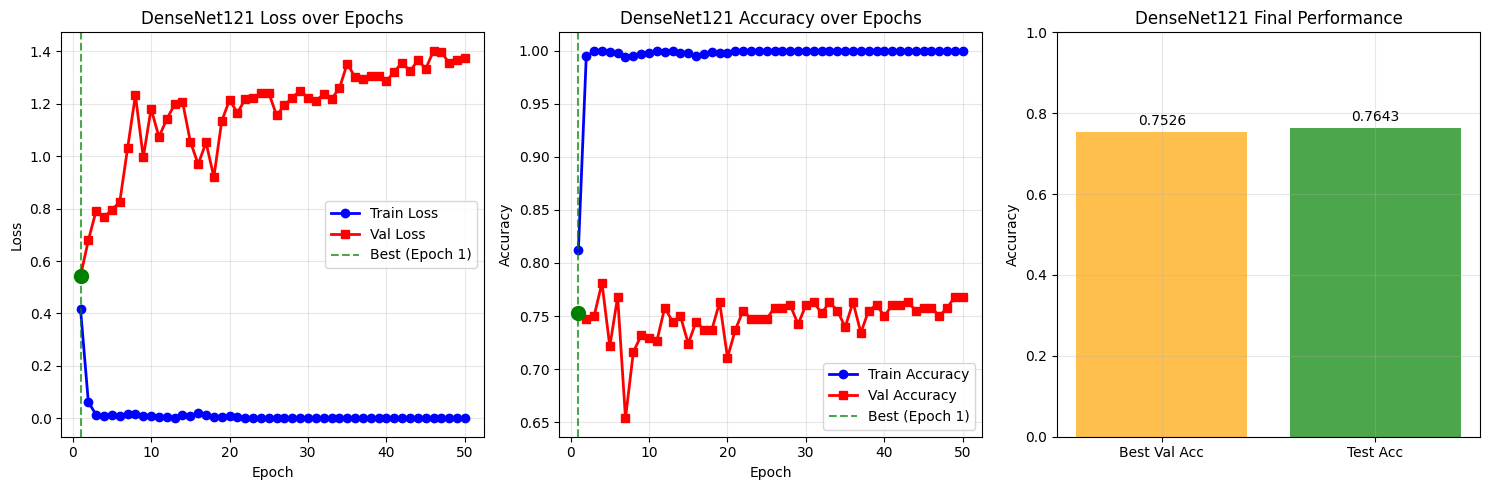


⏰ Final Timing Summary:
│ Total Training: 1521.61s (25.4 min)
│ Average per Epoch: 30.43s
│ Testing Time: 7.02s
│ Total Runtime: 1528.63s

🌐 DenseNet121 Advantages:
│ Dense Connections: Every layer connects to every other layer
│ Parameter Efficient: ~8M parameters (vs ~25M ResNet50)
│ Feature Reuse: Excellent gradient flow and feature reuse
│ Strong Performance: Often matches/exceeds ResNet with fewer parameters


In [10]:
import pandas as pd
import torch.optim as optim
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\n📋 Training Configuration:")
print(f"│ Model: DenseNet121 (pretrained)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 32")
print(f"│ Device: {device}")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\n🚀 Starting DenseNet121 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_densenet121_pretrained.pth')
    print(f"\n💾 Best model saved as 'best_cricket_densenet121.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_densenet121_history_pretrained.csv', index=False)
print("\n💾 Training history saved to 'cricket_densenet121_history_pretrained.csv'")

print(f"\n🎉 DenseNet121 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (DenseNet121):")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_densenet121.pth - Best model weights")
print(f"│ cricket_densenet121_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - DenseNet121 Confusion Matrix (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("DenseNet121 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("DenseNet121 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("DenseNet121 Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model Comparison Info
print(f"\n🌐 DenseNet121 Advantages:")
print(f"│ Dense Connections: Every layer connects to every other layer")
print(f"│ Parameter Efficient: ~8M parameters (vs ~25M ResNet50)")
print(f"│ Feature Reuse: Excellent gradient flow and feature reuse")
print(f"│ Strong Performance: Often matches/exceeds ResNet with fewer parameters")

In [11]:
import tempfile
import os
# Calculate model parameters

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)  # Clean up temporary file

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model file size: {model_size_mb:.2f} MB")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ DenseNet121 features: 1024")
print(f"│ Output classes: {len(classes)}")
print(f"│ Memory efficient: Dense connections")
print(f"│ Growth rate: 32 feature maps per layer")

📊 Total parameters: 6,955,906
📊 Trainable parameters: 6,955,906
📊 Model file size: 27.11 MB
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ DenseNet121 features: 1024
│ Output classes: 2
│ Memory efficient: Dense connections
│ Growth rate: 32 feature maps per layer
